In [1]:
import sys
sys.path.append(r'C:\Users\Jameshuckle\Dropbox\My-Portfolio\AlgorithmicTrading\utils')
from data_util import (download_data_local_check, prep_stock_data, prep_fx_data, calc_sharpe, calc_romad)
from candlestick_embeddings_util import create_candlestick_corpus

from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from datetime import datetime
import yfinance as yf 

pd.options.display.max_rows = 500
pd.options.display.max_columns = 50

EURUSD_1h_2003-2010.csv
data_util.py


In [2]:
### stock data ######
start = '2015-01-01'
end = '2020-05-25'
## download data
all_stock_data = download_data_local_check('SP500', start, end, individual_tickers=None)
loaded_files = prep_stock_data(all_stock_data, filter_start_date_tuple=None) #(2015,1,1)

C:\Users\Jameshuckle\Dropbox\My-Portfolio\AlgorithmicTrading\data\SP500_all_stock_data_2015-01-01-2020-05-25.csv
num stocks: 505


OTIS does not have enough data
BF.B does not have enough data
UA has moves that are too large
HWM has moves that are too large
OXY has moves that are too large
BRK.B does not have enough data
TT has moves that are too large
CARR does not have enough data
APA has moves that are too large



In [3]:
sp500_index = yf.download('^GSPC', start, end)
sp500_index = sp500_index[['Open','High','Low','Close']]
sp500_index = sp500_index.ffill()
sp500_index.index.name = 'Gmt time'
loaded_files['SP500'] = sp500_index

[*********************100%***********************]  1 of 1 completed


### Use SP500 close prices

In [4]:
len_sp500 = len(sp500_index)
close_prices_raw = {}
for stock, data in loaded_files.items():
    if len(data) < len_sp500:
        print(stock,'does not have enough data')
        continue
    close_prices_raw[stock] = data['Close']

FOX does not have enough data
DOW does not have enough data
FOXA does not have enough data
IR does not have enough data
HPE does not have enough data
VIAC does not have enough data
PYPL does not have enough data
CTVA does not have enough data
WRK does not have enough data
FTV does not have enough data
LW does not have enough data
KHC does not have enough data


In [5]:
close_prices = pd.DataFrame(close_prices_raw)
close_prices_covid = close_prices[close_prices.index > datetime(2020,2,19)]

### covid SP500 correlation filter

In [6]:
corr_data_covid = close_prices_covid.corr()
corr_data_2015 = close_prices.corr()

In [7]:
print('NO. stocks with less than 0.5 corr to SP500 after covid:',(corr_data_covid['SP500'] < 0.5).sum())
corr_data_covid['SP500'].sort_values()

NO. stocks with less than 0.5 corr to SP500 after covid: 30


CTXS    -0.131475
KR      -0.058295
COG     -0.033383
HRL      0.010043
GILD     0.018058
CLX      0.057759
REGN     0.110024
WBA      0.172587
WMT      0.230459
SJM      0.233826
GIS      0.248532
DLR      0.266364
CINF     0.273019
UPS      0.280579
ED       0.293118
CAG      0.326153
TTWO     0.335875
CPB      0.346144
MKTX     0.369327
LUV      0.369349
LLY      0.378015
AMZN     0.421080
NEM      0.429633
AKAM     0.446079
INCY     0.453642
NFLX     0.478714
K        0.479377
CNC      0.481345
VRTX     0.481684
WEC      0.488293
AAL      0.506511
ATVI     0.509539
WST      0.510171
DAL      0.511690
PSA      0.516203
FTNT     0.531358
DXCM     0.535804
EXR      0.537309
IVZ      0.541095
AMGN     0.546087
COTY     0.548134
DG       0.550850
BXP      0.551622
GE       0.552503
ABT      0.553011
ABMD     0.558474
WU       0.569619
SLG      0.569751
ILMN     0.570083
CMS      0.570840
WFC      0.572926
L        0.579395
UAL      0.581651
RE       0.582251
PBCT     0.584715
FRT      0

In [8]:
un_corr_stocks = list(corr_data_covid['SP500'].sort_values()[0:30].index)

### 2015 sharpe and romad filter

In [9]:
stock_sharpes_raw = {}
stock_romads_raw = {}
for stock in list(close_prices.columns):
    stock_sharpes_raw[stock] = calc_sharpe(close_prices[stock].pct_change())
    stock_romads_raw[stock] = calc_romad(close_prices[stock].pct_change())
    
stock_sharpes = pd.Series(stock_sharpes_raw)
stock_romads = pd.Series(stock_romads_raw)
stock_sharpes_raw['SP500'], stock_romads_raw['SP500']

(0.6, 0.14)

In [10]:
un_corr_stock_sharpes = stock_sharpes[un_corr_stocks + ['SP500']]
un_corr_stock_sharpes = un_corr_stock_sharpes[un_corr_stock_sharpes >= un_corr_stock_sharpes['SP500']]

un_corr_stock_romads = stock_romads[un_corr_stocks + ['SP500']]
un_corr_stock_romads = un_corr_stock_romads[un_corr_stock_romads >= un_corr_stock_romads['SP500']]

best_stocks = set(list(set(un_corr_stock_sharpes.index) & set(un_corr_stock_romads.index)))
best_stocks_non_sp = set([s for s in best_stocks if s != 'SP500'])
print('best stocks:',best_stocks)

best_stock_info = pd.DataFrame(
    [pd.Series(un_corr_stock_sharpes[best_stocks], name='sharpe'),
     pd.Series(un_corr_stock_romads[best_stocks], name='romad'),
     pd.Series(corr_data_covid['SP500'][best_stocks], name='corr'),
     ]).transpose()

best_stock_info

best stocks: {'NFLX', 'MKTX', 'DLR', 'CLX', 'AKAM', 'LLY', 'HRL', 'CTXS', 'NEM', 'TTWO', 'WEC', 'SP500', 'CNC', 'AMZN'}


,sharpe,romad,corr
NFLX,1.59,0.74,0.478714
MKTX,1.89,0.97,0.369327
DLR,1.40,0.60,0.266364
CLX,0.96,0.55,0.057759
AKAM,0.64,0.18,0.446079
LLY,1.07,0.63,0.378015
HRL,0.68,0.21,0.010043
CTXS,3.23,0.76,-0.131475
NEM,0.88,0.35,0.429633
TTWO,1.14,0.58,0.335875


### Plot data

In [11]:
best_stock_data_2015 = close_prices.loc[:, best_stocks]
best_stock_data_covid = close_prices_covid.loc[:, best_stocks]

In [38]:
import matplotlib.dates as mdates
from matplotlib.ticker import (AutoMinorLocator)

plt.rcParams["figure.dpi"] = 200

params = {
    'axes.titlesize':16, # title size
    'axes.titleweight':'bold',
    'axes.labelsize': 12, # axis title size
    'axes.labelweight':'bold',
    'xtick.labelsize':10, # x-axis label size
    'ytick.labelsize':10, # y-axis label size
    'legend.fontsize': 10, # legend size
}
plt.rcParams.update(params)

# Set the locator
locator = mdates.MonthLocator()  # every month
# Specify the format - %b gives us Jan, Feb...
fmt = mdates.DateFormatter('%b %Y')

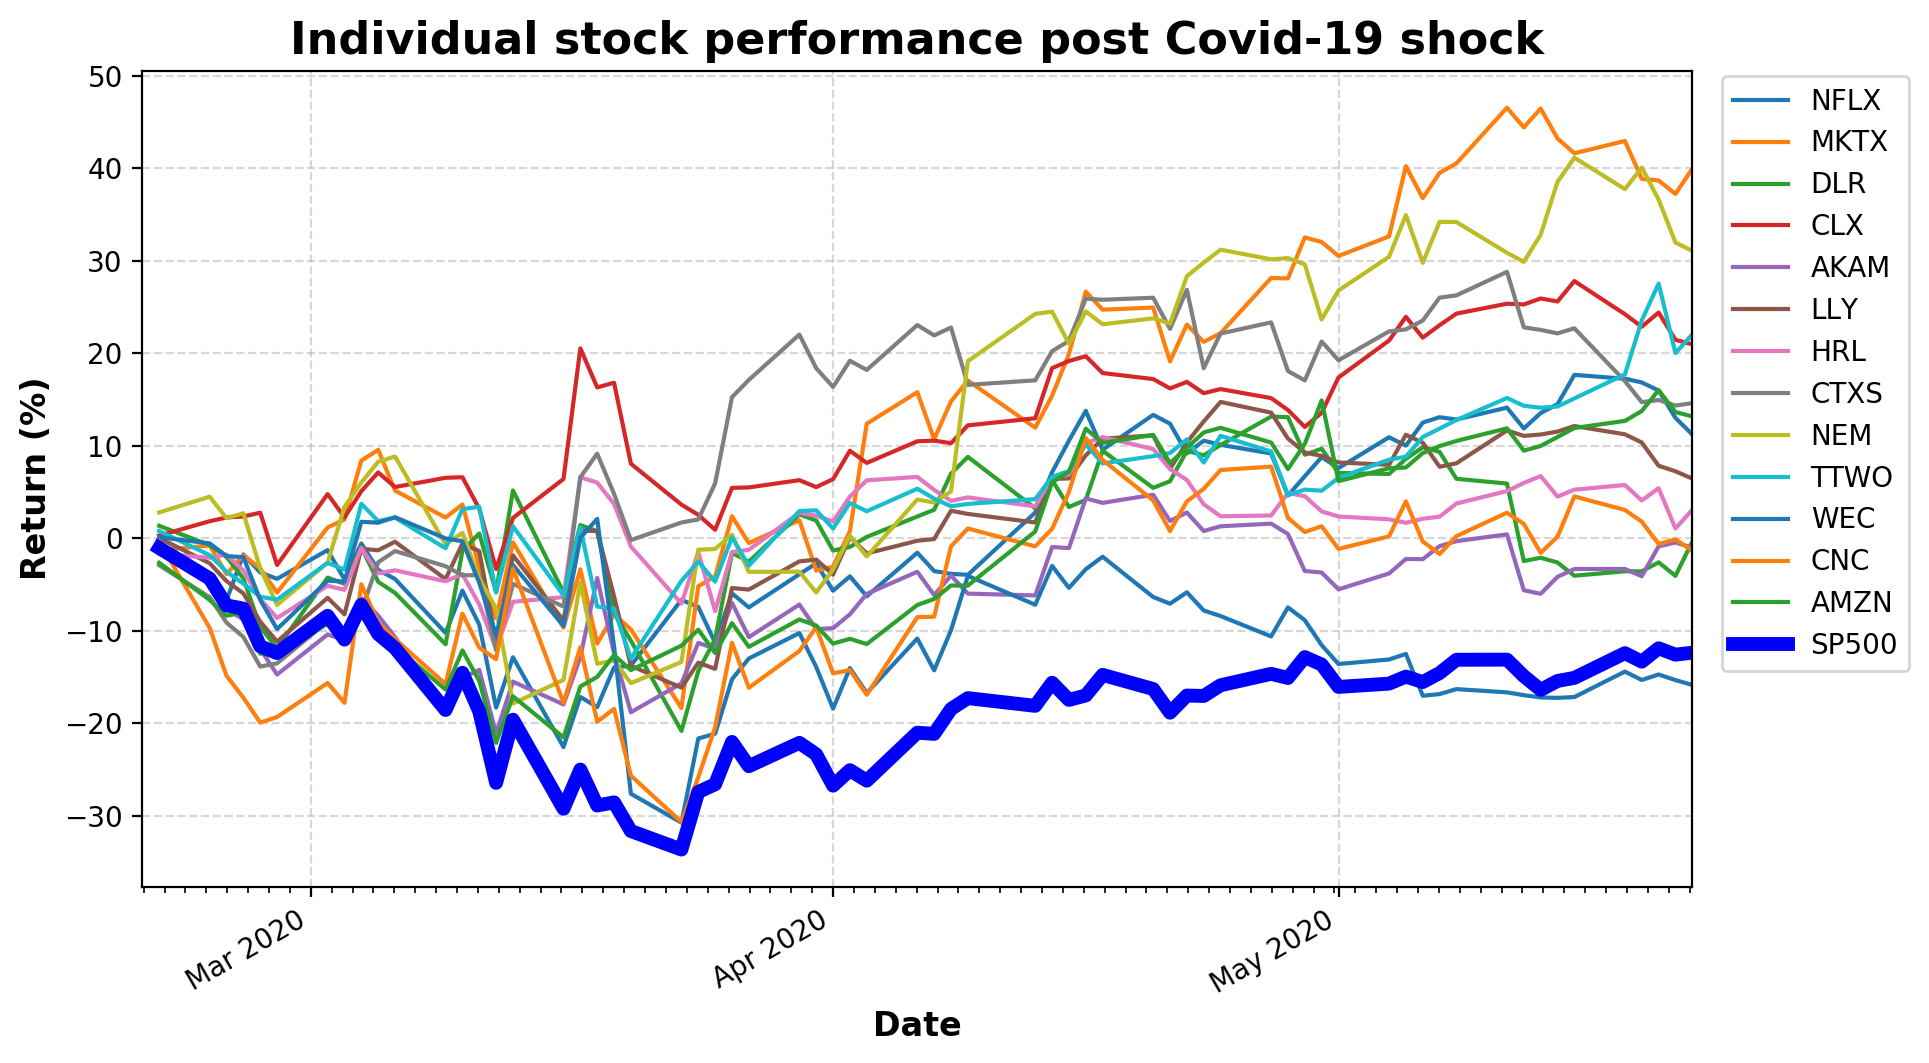

In [67]:
best_stock_returns_covid = ((1 + best_stock_data_covid.pct_change()).cumprod() -1) * 100

ax = best_stock_returns_covid[best_stocks_non_sp].plot(figsize=(10,6), title='Individual stock performance post Covid-19 shock')
best_stock_returns_covid[['SP500']].plot(lw=5, c='blue', ax=ax)
ax.legend(bbox_to_anchor=(1.01, 1.01))
ax.set_ylabel('Return (%)')
ax.set_xlabel('Date')
ax.grid(linestyle="--", alpha=0.5)


X = plt.gca().xaxis
X.set_major_locator(locator)
# Specify formatter
X.set_major_formatter(fmt)
X.set_minor_locator(AutoMinorLocator(25))

# max_fill = best_stock_returns_covid.max(axis=1)
# min_fill = best_stock_returns_covid.min(axis=1)
# ax.fill_between(max_fill.index, min_fill.values, max_fill.values, alpha=0.3, color='lightgreen')

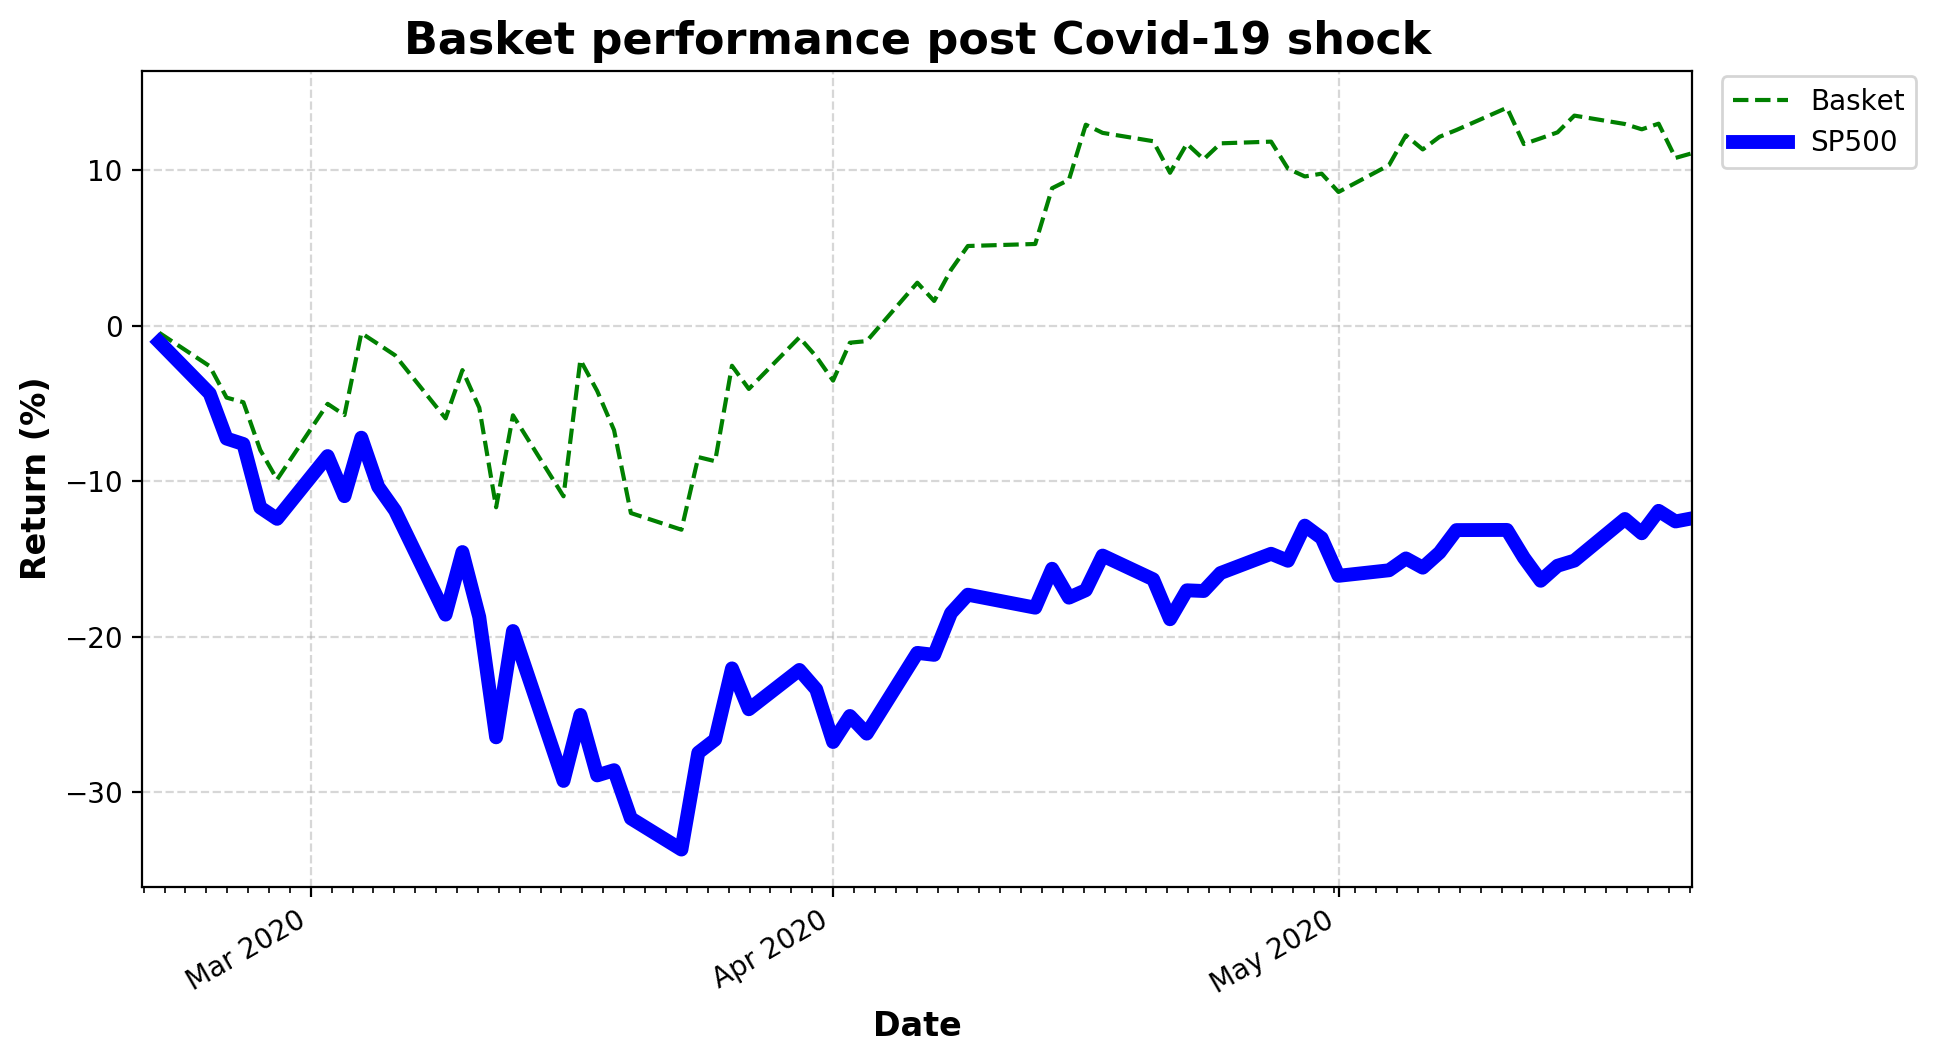

In [66]:
ax = best_stock_returns_covid[best_stocks_non_sp].mean(axis=1).plot(figsize=(10, 6), style='g--' ,
                                                                    title='Basket performance post Covid-19 shock')
best_stock_returns_covid[['SP500']].plot(c='blue', lw=5, ax=ax)
ax.legend(bbox_to_anchor=(1.01, 1.01), labels=['Basket','SP500'])
ax.set_ylabel('Return (%)')
ax.set_xlabel('Date')
ax.grid(linestyle="--", alpha=0.5)


X = plt.gca().xaxis
X.set_major_locator(locator)
# Specify formatter
X.set_major_formatter(fmt)
X.set_minor_locator(AutoMinorLocator(25))

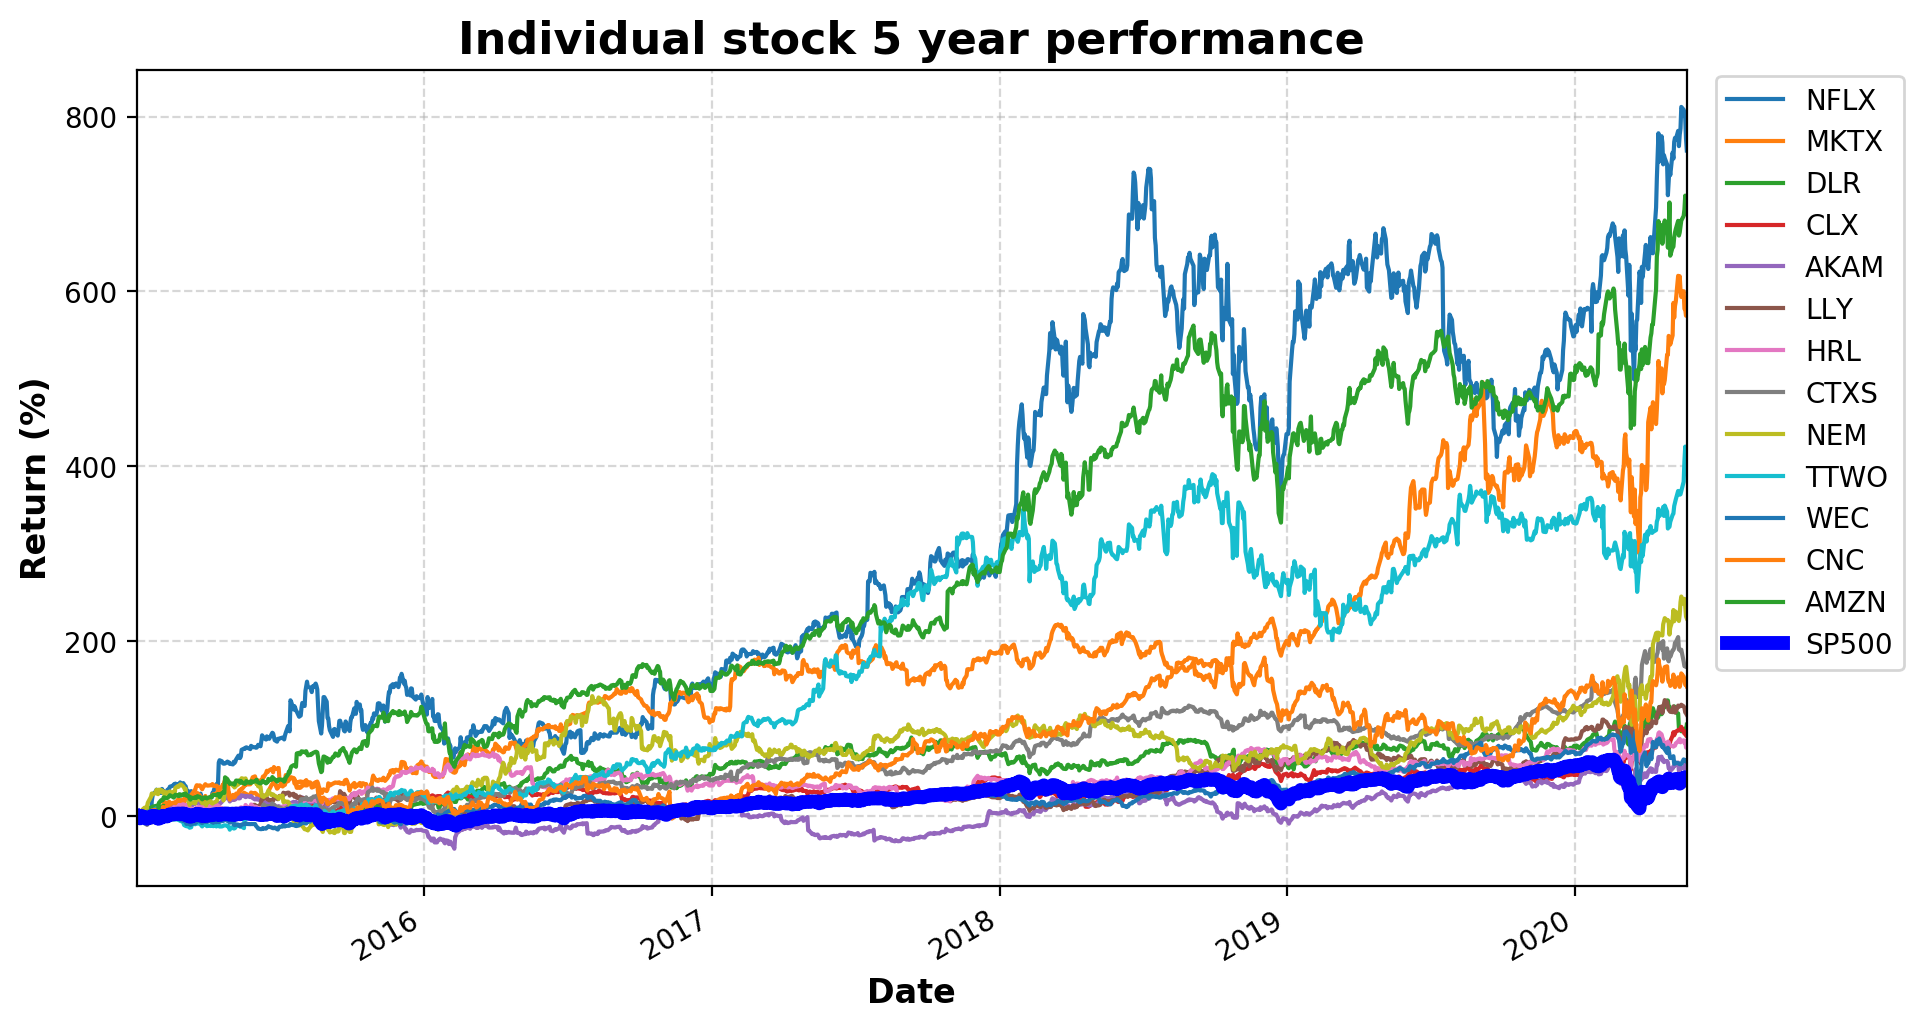

In [68]:
best_stock_returns_2015 = ((1 + best_stock_data_2015.pct_change()).cumprod() -1) * 100

ax = best_stock_returns_2015[best_stocks_non_sp].plot(figsize=(10,6), title='Individual stock 5 year performance')
best_stock_returns_2015[['SP500']].plot(lw=5, c='blue', ax=ax)

ax.legend(bbox_to_anchor=(1.01, 1.01))
ax.set_ylabel('Return (%)')
ax.set_xlabel('Date')
ax.grid(linestyle="--", alpha=0.5)


# max_fill = best_stock_returns_2015.max(axis=1)
# min_fill = best_stock_returns_2015.min(axis=1)
# ax.fill_between(max_fill.index, min_fill.values, max_fill.values, alpha=0.3, color='lightgreen')

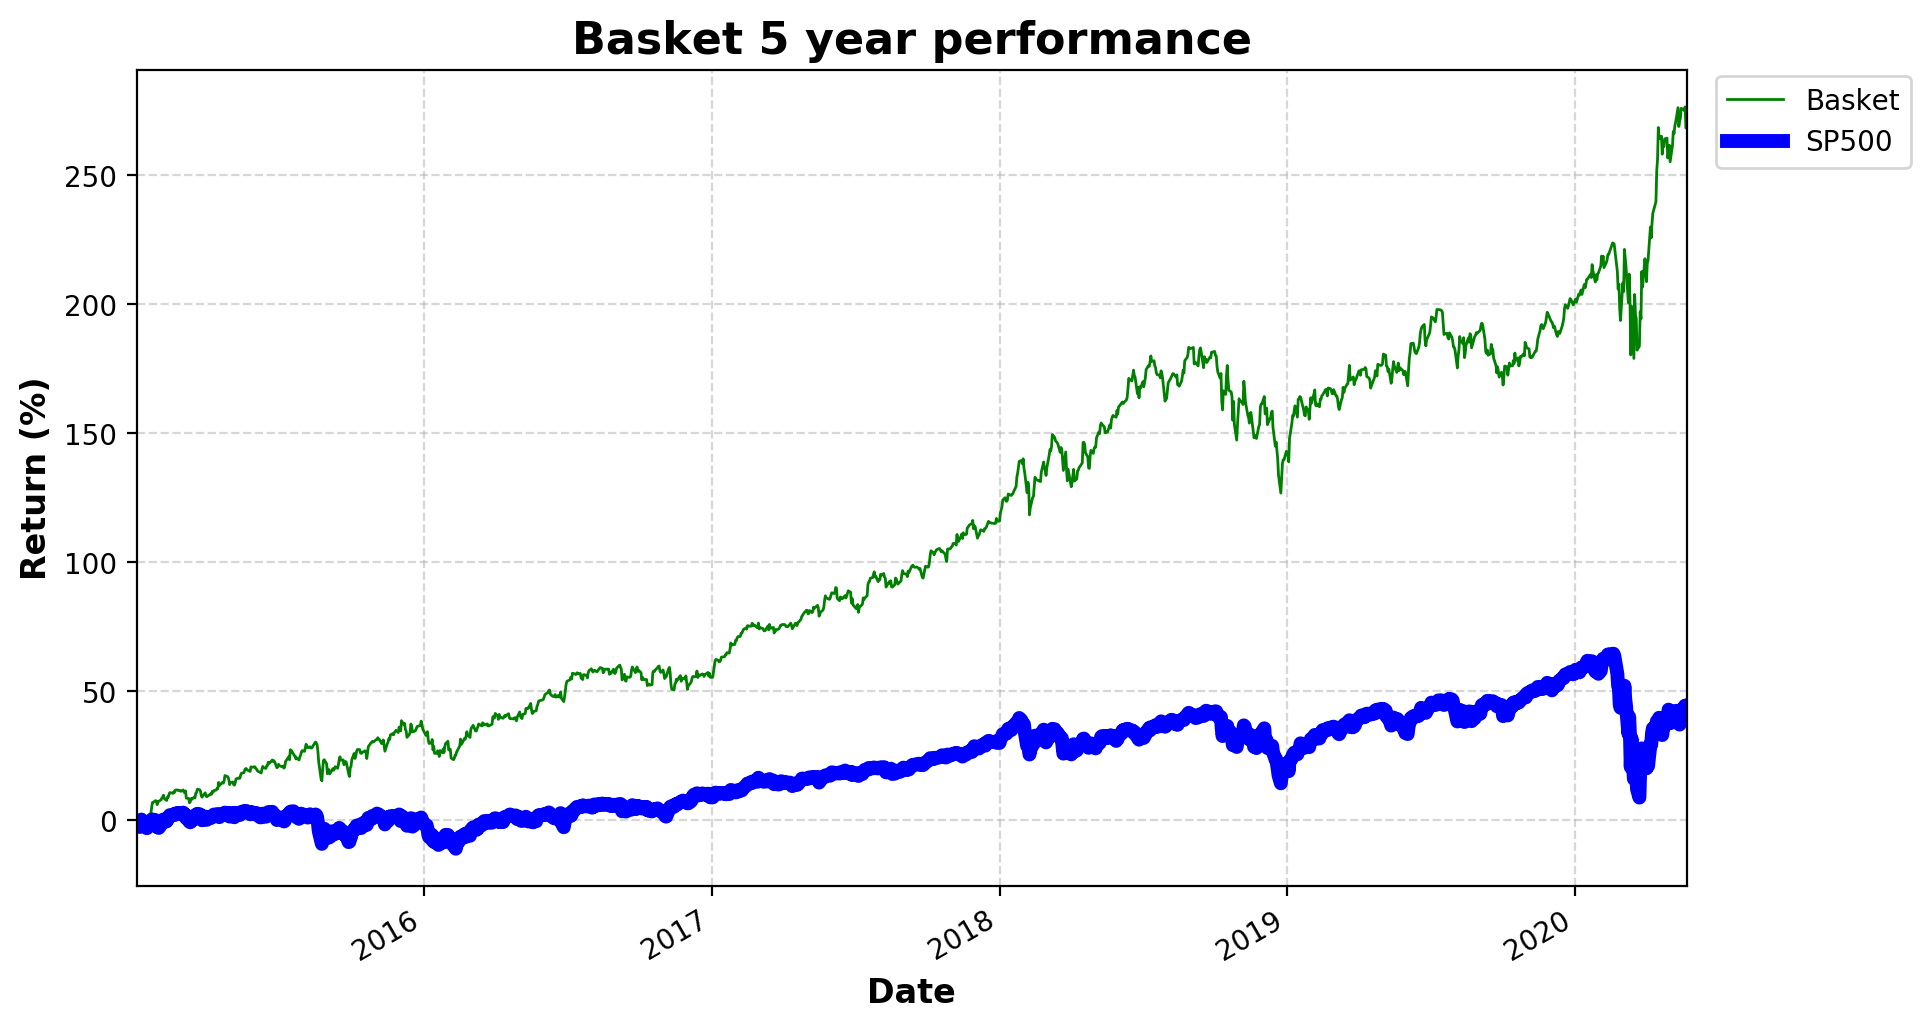

In [65]:
ax = best_stock_returns_2015[best_stocks_non_sp].mean(axis=1).plot(figsize=(10,6), style='g-', lw=1, 
                                                                   title='Basket 5 year performance')
best_stock_returns_2015[['SP500']].plot(lw=5, c='blue', ax=ax)

ax.legend(bbox_to_anchor=(1.01, 1.01), labels=['Basket','SP500'])
ax.set_ylabel('Return (%)')
ax.set_xlabel('Date')
ax.grid(linestyle="--", alpha=0.5)